###Problem:
- We are trying to train a classifier to identify loneliness in Instagram DM Data
- We want to run inference on real DM data from patients, but we don't have any ground truths (much less enough data)
- Proposed solution - we used COT prompting to apply style transfer to Reddit posts from r/CasualConversations and r/SeriousConversations to make synthetic DMs. 
- We labeled them as being lonely or not lonely based on the presence of specific loneliness-related keywords.
- However, there are some messages that will be lonely without the presence of keywords and not lonely with the presence of keywords. 
- What if we labeled data based on cluster membership using semantic embeddings instead of just keyword presence?
- On another note, I also want to see if the synthetic DMs line up with the real DMs w.r.t structure.
### Goals
1. Can we get defined lonely and not lonely clusters using k means - reddit data
2. Turn reddit posts, synthetic DMs and momentum DMs into embeddings. How similar are they? Use tSNE and or UMAP


In [1]:
#imports
import pandas as pd
import os
import emoji
import glob
from sentence_transformers import SentenceTransformer
import numpy as np
#import umap
from cuml import UMAP
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
#make our dataframes
serious_path = "SeriousConversation_submissions_deduplicated.csv"
casual_path = "CasualConversations_submissions_deduplicated.csv"

# columns: score,created_utc,####title#####,approved_at_utc,approved_by,archived,author_flair_text,banned_at_utc,banned_by,can_mod_post,downs,is_original_content,is_video,likes,locked,mod_note,mod_reason_by,mod_reason_title,mod_reports,name,num_comments,
# num_reports,over_18,removal_reason,removed_by,removed_by_category,report_reasons,retrieved_on,spoiler,ups,upvote_ratio,user_reports,view_count,author,permalink,###selftext_or_url_reference####

lonely_path = "lonely_dedupe.csv"
#columns: Index,Title,Content

# --- Serious Reddit Posts ---
df_serious = pd.read_csv(serious_path, low_memory=False)
df_serious['title'] = df_serious['title'].fillna('').astype(str).str.strip()
df_serious['selftext_or_url_reference'] = df_serious['selftext_or_url_reference'].fillna('').astype(str).str.strip()
df_serious['sentence'] = df_serious['title'] + '. ' + df_serious['selftext_or_url_reference']
df_serious = df_serious[['sentence']]

# --- Casual Reddit Posts ---
df_casual = pd.read_csv(casual_path, low_memory=False)
df_casual['title'] = df_casual['title'].fillna('').astype(str).str.strip()
df_casual['selftext_or_url_reference'] = df_casual['selftext_or_url_reference'].fillna('').astype(str).str.strip()
df_casual['sentence'] = df_casual['title'] + '. ' + df_casual['selftext_or_url_reference']
df_casual = df_casual[['sentence']]

# --- Lonely Synthetic DMs ---
df_lonely = pd.read_csv(lonely_path)
df_lonely['Title'] = df_lonely['Title'].fillna('').astype(str).str.strip()
df_lonely['Content'] = df_lonely['Content'].fillna('').astype(str).str.strip()
df_lonely['sentence'] = df_lonely['Title'] + '. ' + df_lonely['Content']
df_lonely = df_lonely[['sentence']]



momentum_path = "path/here" #this is a directory of parquet files
#columns: Sender_ID,Message,UTC_Timestamp,Conversation_ID,Source,expected_sender
# --- Find all .parquet files ---
parquet_files = glob.glob(os.path.join(momentum_path, "*.parquet"))

# --- Collect DMs ---
all_dms = []

for file in parquet_files:
    try:
        df = pd.read_parquet(file, columns=['Message'])  # only read Message column
        df = df.dropna(subset=['Message'])               # remove empty messages
        all_dms.append(df)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# --- Combine all into one DataFrame ---
df_momentum = pd.concat(all_dms, ignore_index=True)
df_momentum.rename(columns={'Message': 'sentence'}, inplace=True)


casual_dm_path = "casual_ckpt_0.7_0.7.csv"
serious_dm_path = "serious_ckpt_0.7_0.7.csv"
lonely_dm_path = "lonely_ckpt_0.5_0.7.csv"
#columns: Index,Reddit Post,DM,Sentiment

# --- Filepaths ---
casual_dm_path  = "casual_ckpt_0.7_0.7.csv"
serious_dm_path = "serious_ckpt_0.7_0.7.csv"
lonely_dm_path  = "lonely_ckpt_0.5_0.7.csv"

# --- Load and extract DMs ---
df_casual_dm  = pd.read_csv(casual_dm_path)[['DM']].rename(columns={'DM': 'sentence'})
df_serious_dm = pd.read_csv(serious_dm_path)[['DM']].rename(columns={'DM': 'sentence'})
df_lonely_dm  = pd.read_csv(lonely_dm_path)[['DM']].rename(columns={'DM': 'sentence'})

# --- Concatenate into one big DataFrame ---


def convert_emojis_to_text(text):
    if isinstance(text, str):
        return emoji.demojize(text, delimiters=(":", ":"))  # e.g. 😀 → :grinning_face:
    return text

# Apply emoji demojization
df_serious['sentence'] = df_serious['sentence'].apply(convert_emojis_to_text)
df_casual['sentence'] = df_casual['sentence'].apply(convert_emojis_to_text)
df_lonely['sentence'] = df_lonely['sentence'].apply(convert_emojis_to_text)
df_serious_dm['sentence'] = df_serious_dm['sentence'].apply(convert_emojis_to_text)
df_casual_dm['sentence'] = df_casual_dm['sentence'].apply(convert_emojis_to_text)
df_lonely_dm['sentence'] = df_lonely_dm['sentence'].apply(convert_emojis_to_text)

df_synthetic_dms = pd.concat([df_casual_dm, df_serious_dm, df_lonely_dm], ignore_index=True)
#when we do COT prompting to make synthetic DMS we use both reddit title and content as input

In [ ]:
#print a few rows of each dataframe
# --- Prevent truncation of long strings ---
pd.set_option('display.max_colwidth', None)
# --- Sample rows for inspection ---
print(">>> Serious Reddit Posts:")
print(df_serious.head(3), "\n")

print(">>> Casual Reddit Posts:")
print(df_casual.head(10), "\n")

print(">>> Lonely Reddit Posts:")
print(df_lonely.head(10), "\n")

print(">>> Real Momentum DMs:")
print(df_momentum.head(3), "\n")

print(">>> Serious synthetic dms:")
print(df_serious_dm.head(3), "\n")

print(">>> Casualsynthetic dms:")
print(df_casual_dm.head(10), "\n")

print(">>> Lonely synthetic dms:")
print(df_lonely_dm.head(10), "\n")

# print(">>> All Synthetic DMs (Casual + Serious + Lonely):")
# print(df_synthetic_dms.head(3), "\n")


In [3]:
#turn reddit posts, synthetic DMs, momentum DMs into embeddings
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')  # auto-uses GPU

def embed_sentences(df, batch_size=64):
    sentences = df['sentence'].tolist()
    embeddings = model.encode(
        sentences,
        batch_size=batch_size,
        show_progress_bar=True,
        convert_to_numpy=True,
        device='cuda'
    )
    return embeddings

# Reddit embeddings
emb_serious  = embed_sentences(df_serious)
emb_casual   = embed_sentences(df_casual)
emb_lonely   = embed_sentences(df_lonely)

# Synthetic DMs
emb_synthetic = embed_sentences(df_synthetic_dms)

# Real DMs (Momentum)
emb_momentum  = embed_sentences(df_momentum)


Batches:   0%|          | 0/705 [00:00<?, ?it/s]

Batches:   0%|          | 0/922 [00:00<?, ?it/s]

Batches:   0%|          | 0/1433 [00:00<?, ?it/s]

Batches:   0%|          | 0/1208 [00:00<?, ?it/s]

Batches:   0%|          | 0/17946 [00:00<?, ?it/s]

In [12]:


# Step 1: Stack embeddings
all_embeddings = np.vstack([
    emb_serious,
    emb_casual,
    emb_lonely,
    emb_synthetic,
    emb_momentum
])

# Step 2: Build labels
labels = (
    ['reddit_serious']   * len(emb_serious) +
    ['reddit_casual']    * len(emb_casual) +
    ['reddit_lonely']    * len(emb_lonely) +
    ['synthetic_dm']     * len(emb_synthetic) +
    ['real_dm']          * len(emb_momentum)
)

# Step 3: Run UMAP (GPU)
print("Running UMAP on GPU...")
reducer = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding_2d = reducer.fit_transform(all_embeddings)




Running UMAP on GPU...


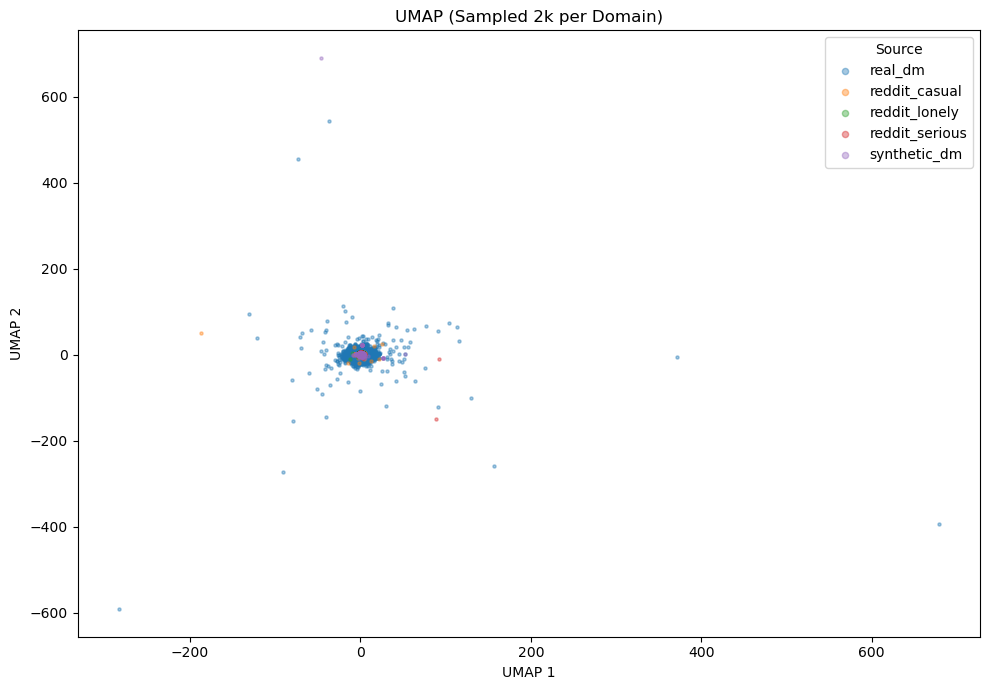

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Combine UMAP + labels ---
df_umap = pd.DataFrame({
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'label': labels
})

# --- Step 2: Subsample ~2000 per domain ---
df_sampled = df_umap.groupby('label').apply(lambda x: x.sample(n=2000, random_state=42)).reset_index(drop=True)

# --- Step 3: Plot ---
plt.figure(figsize=(10, 7))

unique_labels = sorted(df_sampled['label'].unique())
colors = plt.cm.tab10.colors

for i, label in enumerate(unique_labels):
    subset = df_sampled[df_sampled['label'] == label]
    plt.scatter(subset['x'], subset['y'], s=5, label=label, color=colors[i % len(colors)], alpha=0.4)

plt.title("UMAP (Sampled 2k per Domain)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Source", loc='best', markerscale=2)
plt.grid(False)
plt.tight_layout()
plt.show()


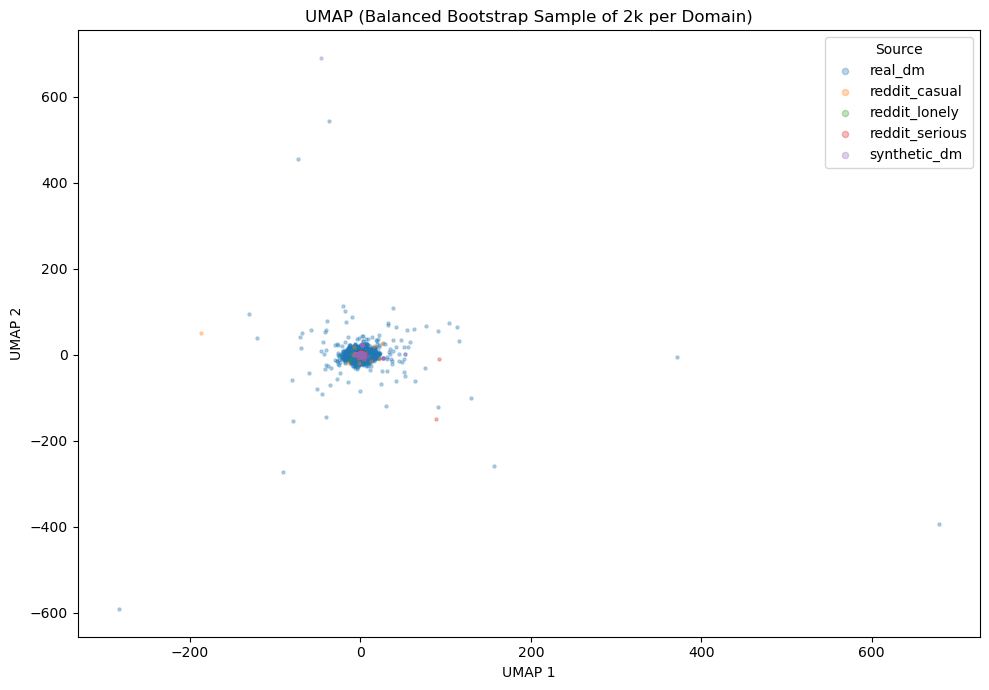

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Combine UMAP output and labels ---
df_umap = pd.DataFrame({
    'x': embedding_2d[:, 0],
    'y': embedding_2d[:, 1],
    'label': labels
})

# --- Step 2: Set target size per class ---
target_size = 2000

# --- Step 3: Undersample real_dm, bootstrap others ---
df_balanced = (
    df_umap.groupby('label', group_keys=False)
    .apply(lambda g: g.sample(target_size, replace=(len(g) < target_size), random_state=42))
    .reset_index(drop=True)
)

# --- Step 4: Plot ---
plt.figure(figsize=(10, 7))

unique_labels = sorted(df_balanced['label'].unique())
colors = plt.cm.tab10.colors

for i, label in enumerate(unique_labels):
    subset = df_balanced[df_balanced['label'] == label]
    plt.scatter(subset['x'], subset['y'], s=5, label=label, color=colors[i % len(colors)], alpha=0.3)

plt.title("UMAP (Balanced Bootstrap Sample of 2k per Domain)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Source", loc='best', markerscale=2)
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
#Train a simple logistic regression or MLP to distinguish Reddit vs. Instagram embeddings.
'''
If it can classify them with high accuracy, then there's a strong domain shift.
If it performs poorly (near 50% accuracy), embeddings are largely domain-invarian
'''

In [4]:
#do clustering using k means, k = 2, lonely, not lonely
#use the presence of keywords as a weak label to compute the initial centroids before I run K means
import numpy as np

centroid_lonely = np.mean(emb_lonely, axis=0)
centroid_nonlonely = np.mean(np.vstack([emb_serious, emb_casual]), axis=0)

custom_init = np.vstack([centroid_lonely, centroid_nonlonely])

from sklearn.cluster import KMeans

# Combine all embeddings for clustering
emb_all = np.vstack([emb_lonely, emb_serious, emb_casual])
labels_all = ['lonely'] * len(emb_lonely) + ['nonlonely'] * (len(emb_serious) + len(emb_casual))

kmeans = KMeans(n_clusters=2, init=custom_init, n_init=1, random_state=42)
cluster_ids = kmeans.fit_predict(emb_all)


from sklearn.metrics import silhouette_score

score = silhouette_score(emb_all, cluster_ids)  # X = data, labels = KMeans cluster labels
print("Silhouette Score:", score)



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Silhouette Score: 0.074885264


In [5]:
import pandas as pd

df = pd.DataFrame({
    'cluster': cluster_ids,
    'label': labels_all
})

# Cluster/label agreement
print(df.groupby(['cluster', 'label']).size().unstack(fill_value=0))


label    lonely  nonlonely
cluster                   
0         80105      19984
1         11568      84109


In [6]:
# Step 1: Track lengths
len_lonely  = len(emb_lonely)
len_serious = len(emb_serious)
len_casual  = len(emb_casual)

# Step 2: Split cluster_ids accordingly
cluster_ids_lonely   = cluster_ids[:len_lonely]
cluster_ids_serious  = cluster_ids[len_lonely:len_lonely + len_serious]
cluster_ids_casual   = cluster_ids[len_lonely + len_serious:]

# Step 3: Add cluster column to each original dataframe
df_lonely['cluster']  = cluster_ids_lonely
df_serious['cluster'] = cluster_ids_serious
df_casual['cluster']  = cluster_ids_casual

df_lonely.to_csv("lonely_with_clusters.csv", index=False)
df_serious.to_csv("serious_with_clusters.csv", index=False)
df_casual.to_csv("casual_with_clusters.csv", index=False)



In [7]:
print("Lonely:")
print(df_lonely['cluster'].value_counts().sort_index())

print("\nSerious:")
print(df_serious['cluster'].value_counts().sort_index())

print("\nCasual:")
print(df_casual['cluster'].value_counts().sort_index())


Lonely:
0    80105
1    11568
Name: cluster, dtype: int64

Serious:
0    13026
1    32075
Name: cluster, dtype: int64

Casual:
0     6958
1    52034
Name: cluster, dtype: int64


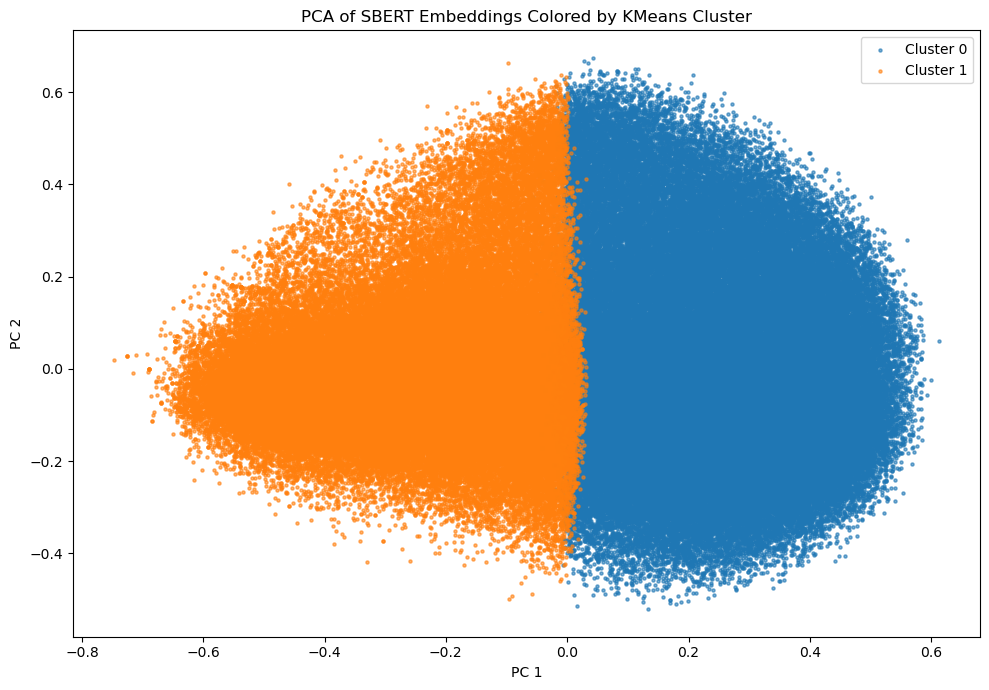

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
emb_pca = pca.fit_transform(emb_all)

# Build DataFrame
df_pca = pd.DataFrame({
    'x': emb_pca[:, 0],
    'y': emb_pca[:, 1],
    'cluster': cluster_ids.astype(str),
    'label': labels_all
})

# Plot by cluster
plt.figure(figsize=(10, 7))
for cluster in sorted(df_pca['cluster'].unique()):
    subset = df_pca[df_pca['cluster'] == cluster]
    plt.scatter(subset['x'], subset['y'], s=5, alpha=0.6, label=f"Cluster {cluster}")

plt.title("PCA of SBERT Embeddings Colored by KMeans Cluster")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


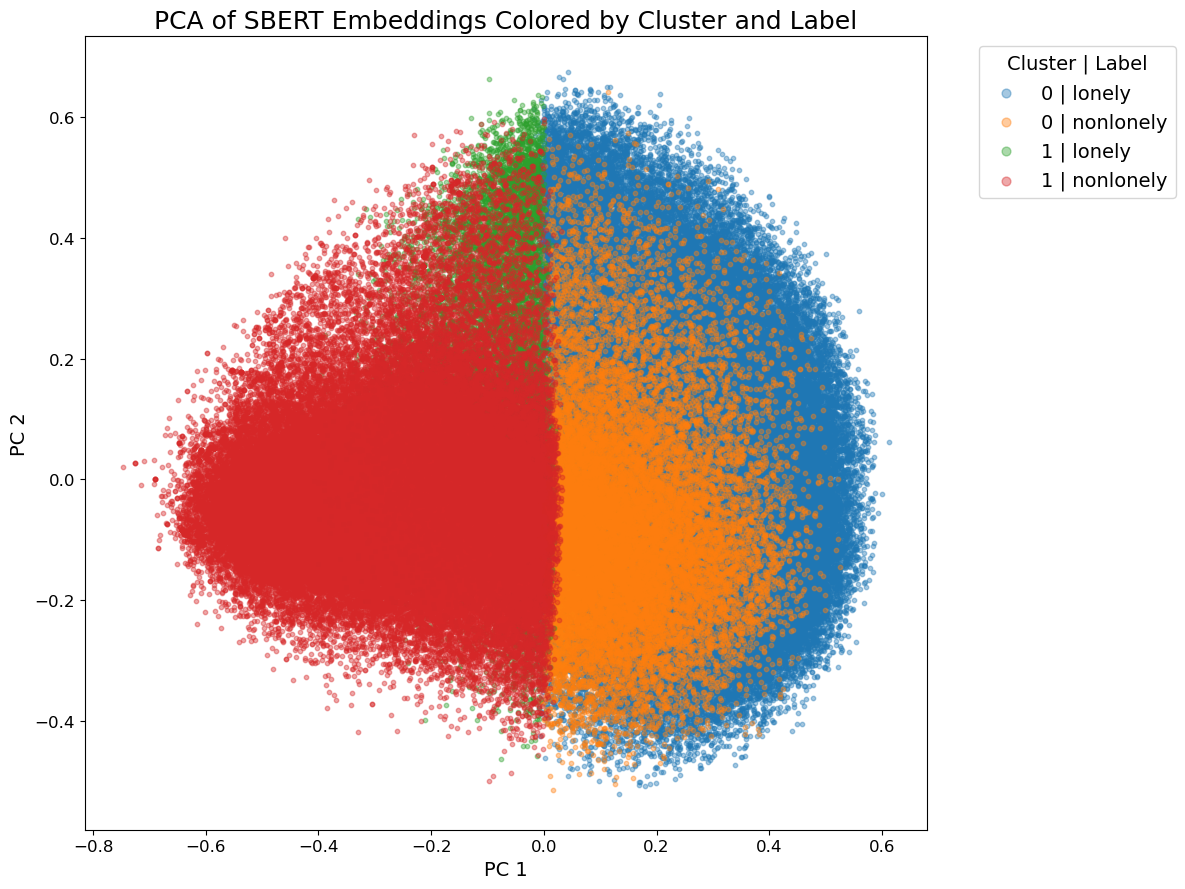

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Reduce SBERT embeddings to 2D via PCA
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(emb_all)

# Step 2: Build DataFrame with cluster + label info
df_pca = pd.DataFrame({
    'x': emb_pca[:, 0],
    'y': emb_pca[:, 1],
    'cluster': cluster_ids.astype(str),
    'label': labels_all
})

# Create composite group name (e.g., "0 | lonely")
df_pca['group'] = df_pca['cluster'] + ' | ' + df_pca['label']

# Step 3: Plot
plt.figure(figsize=(12, 9))
unique_groups = sorted(df_pca['group'].unique())

# Assign colors
colors = plt.cm.tab10.colors

for i, group in enumerate(unique_groups):
    subset = df_pca[df_pca['group'] == group]
    plt.scatter(subset['x'], subset['y'], s=10, alpha=0.4,
                label=group, color=colors[i % len(colors)])

# Customize plot fonts
plt.title("PCA of SBERT Embeddings Colored by Cluster and Label", fontsize=18)
plt.xlabel("PC 1", fontsize=14)
plt.ylabel("PC 2", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Larger legend
plt.legend(
    title="Cluster | Label",
    title_fontsize=14,
    fontsize = 14,
    markerscale=2,
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.grid(False)
plt.tight_layout()
plt.show()


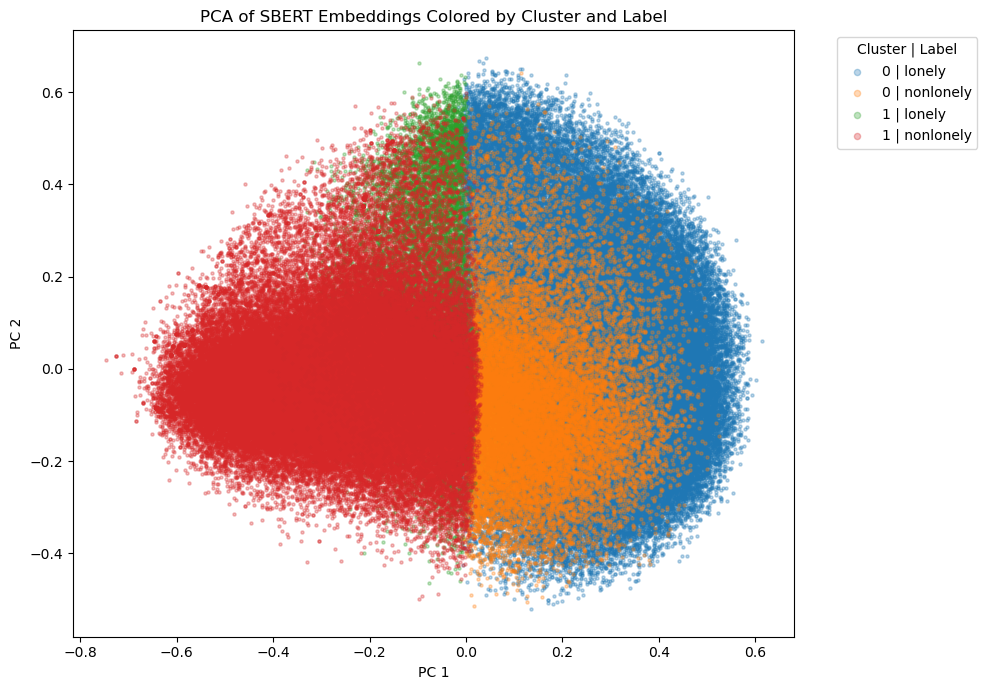

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Reduce SBERT embeddings to 2D via PCA
pca = PCA(n_components=2)
emb_pca = pca.fit_transform(emb_all)

# Step 2: Build DataFrame with cluster + label info
df_pca = pd.DataFrame({
    'x': emb_pca[:, 0],
    'y': emb_pca[:, 1],
    'cluster': cluster_ids.astype(str),
    'label': labels_all
})

# Create composite group name (e.g., "Cluster 0 - lonely")
df_pca['group'] = df_pca['cluster'] + ' | ' + df_pca['label']

# Step 3: Plot
plt.figure(figsize=(10, 7))
unique_groups = sorted(df_pca['group'].unique())

# Assign colors
colors = plt.cm.tab10.colors

for i, group in enumerate(unique_groups):
    subset = df_pca[df_pca['group'] == group]
    plt.scatter(subset['x'], subset['y'], s=5, alpha=0.3,
                label=group, color=colors[i % len(colors)])

plt.title("PCA of SBERT Embeddings Colored by Cluster and Label")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend(title="Cluster | Label", markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(False)
plt.tight_layout()
plt.show()
